# 최종분석코드

## 패키지 임포트

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

import datetime 
import pickle
import os
print(os.getcwd())
import sklearn
print(sklearn.__version__)

D:\user\Desktop\산자부_빅데이터_공모전\과제4\제출파일
1.2.2


## 데이터로드

In [2]:
eleDf=pd.DataFrame()
for i in range(3):
    eleDf=pd.concat([eleDf,pd.read_csv(f'../제12회 산업부 공모전 공공데이터/A0{i}01~A0{i+1}00.csv')])
eleDf.reset_index(drop=True,inplace=True)
print("전력데이터 로드 완료")
weatherDf=pd.read_csv('./강남AWS기상데이터.csv')
print("기상데이터 로드 완료")
popDf=pd.read_csv('./2021~2023_강남구_시간대별_생활인구_주성분.csv')
print("인구주성분 데이터 로드 완료")
valDf=pd.read_excel('./과제 제출물(빅데이터분석과제4_홍길동).xlsx')
print("누락 구간 데이터 로드 완료")

전력데이터 로드 완료
기상데이터 로드 완료
인구주성분 데이터 로드 완료
누락 구간 데이터 로드 완료


## 데이터 수집 및 정제

## 데이터 전처리

In [5]:
class prepareData:
    """전력데이터, 기상데이터, 인구(주성분)데이터를 입력받아 통합 데이터로 만들고, 시간관련 정보를 전처리하는 클래스"""
    def __init__(self,eleDf,valDf, weatherDf=None, popDf = None):
        self.eleDf = eleDf.drop('정전여부', axis=1).dropna()
        self.valDf = valDf.copy()
        self.weatherDf = weatherDf
        self.popDf = popDf
        self.idx=self.eleDf.index
        self.naIdx=self.eleDf[self.eleDf['순방향 유효전력량(KWH)'].isna()].index
        
        self.df=None
        self.mappingInfo={}
        self.evr=None
                
    def mergeDf(self):
        """eleDf와 선택에 따라서 기상데이터나 인구데이터를 통합하여 self.df에 저장하는 코드"""
        ele_copy=self.eleDf.copy()
        
        if self.weatherDf is None and self.popDf is None: # eleDf
            self.df=ele_copy
            
        elif self.weatherDf is not None and self.popDf is None: # eleDf+weatherDf
            weahter_copy=self.weatherDf.copy()
            weahter_copy['일시']=weahter_copy['일시'].apply(lambda x: x[:-3]) # weatherDf가 초단위 까지 표기되어있음(분단위로 머지해야함)
            self.df=ele_copy.merge(weahter_copy, how='left', left_on='검침일', right_on='일시').drop('일시',axis=1)
            self.valDf=self.valDf.merge(weahter_copy, how='left', left_on='검침일', right_on='일시').drop('일시',axis=1)
            
        elif self.weatherDf is None and self.popDf is not None: # eleDf+popDf
            pop_copy=self.popDf.copy()
            ele_copy['기준시점']=ele_copy['검침일'].apply(lambda x: x[:-3])
            self.valDf['기준시점']=self.valDf['검침일'].apply(lambda x: x[:-3])
            pop_copy['기준시점']=pop_copy['기준시점'].apply(lambda x: x[:-6]) # poppcaDf가 초단위 까지 표기되어있음(시단위로 머지해야함)
            self.df=ele_copy.merge(pop_copy, how='left', left_on='기준시점', right_on='기준시점').drop(['기준시점','시간대구분','기준일ID'],axis=1)
            self.valDf=self.valDf.merge(pop_copy, how='left', left_on='기준시점', right_on='기준시점').drop(['기준시점','시간대구분','기준일ID'],axis=1)
            # 생활인구 데이터는 시간단위 이기 때문에 24:00 정보가 없으므로 앞의 값을 이용하여 결측치 채워주기
            
        elif self.weatherDf is not None and self.popDf is not None: # eleDf+weatherDf+popDf
            weahter_copy=self.weatherDf.copy()
            pop_copy=self.popDf.copy()
            weahter_copy['일시']=weahter_copy['일시'].apply(lambda x: x[:-3])
            ele_copy['기준시점']=ele_copy['검침일'].apply(lambda x: x[:-3])
            self.valDf['기준시점']=self.valDf['검침일'].apply(lambda x: x[:-3])
            pop_copy['기준시점']=pop_copy['기준시점'].apply(lambda x: x[:-6])
            
            self.df=ele_copy.merge(weahter_copy, how='left', left_on='검침일', right_on='일시').merge(pop_copy, how='left', left_on='기준시점', right_on='기준시점').drop(['기준시점','시간대구분','기준일ID','일시'],axis=1)
            self.valDf=self.valDf.merge(weahter_copy, how='left', left_on='검침일', right_on='일시').merge(pop_copy, how='left', left_on='기준시점', right_on='기준시점').drop(['기준시점','시간대구분','기준일ID','일시'],axis=1)

    # 0611 변경 코드
    def fillNan(self):
        """기상 및 인구데이터와의 매핑 과정에서 발생한 결측치를 그 이전 값으로 대치(15분 단위로 끊기지 않는 분단위의 존재로 인하여 생겨난 NA들)"""
        self.df=self.df.apply(lambda col: col.fillna(method='ffill') if col.name != '순방향 유효전력량(KWH)' else col)
        self.valDf=self.valDf.apply(lambda col: col.fillna(method='ffill') if col.name != '순방향 유효전력량(KWH)' else col)
    
    def generateTimeFeatures(self):
        """전력데이터에서 시계열 정보를 파생하는 코드""" ## 0614: 1. dayofyear 추가, 2. year, month, day 구하는 방식을 getattr로
        def decomposeStrTime(datetimeStr, whichTime):
            if whichTime=='hour':
                return datetimeStr[-5:-3]
            elif whichTime=='minute':
                return datetimeStr[-2:]
            elif whichTime=='date':
                return datetimeStr[:10]
        self.df['date']=pd.to_datetime(self.df['검침일'].apply(lambda x: decomposeStrTime(x,'date')))
        self.df['year']=self.df['date'].apply(lambda x: getattr(x,'year'))
        self.df['month']=self.df['date'].apply(lambda x: getattr(x,'month'))
        self.df['day']=self.df['date'].apply(lambda x: getattr(x,'day'))
        self.df['dayofyear']=self.df['date'].apply(lambda x: getattr(x,'dayofyear'))
        self.df['hour']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'hour'))
        self.df['minute']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'minute'))
        self.df['weekday']=self.df['date'].apply(lambda x: x.weekday())
        self.df.drop('date', axis=1, inplace=True)
        
        self.valDf['date']=pd.to_datetime(self.valDf['검침일'].apply(lambda x: decomposeStrTime(x,'date')))
        self.valDf['year']=self.valDf['date'].apply(lambda x: getattr(x,'year'))
        self.valDf['month']=self.valDf['date'].apply(lambda x: getattr(x,'month'))
        self.valDf['day']=self.valDf['date'].apply(lambda x: getattr(x,'day'))
        self.valDf['dayofyear']=self.valDf['date'].apply(lambda x: getattr(x,'dayofyear'))
        self.valDf['hour']=self.valDf['검침일'].apply(lambda x: decomposeStrTime(x,'hour'))
        self.valDf['minute']=self.valDf['검침일'].apply(lambda x: decomposeStrTime(x,'minute'))
        self.valDf['weekday']=self.valDf['date'].apply(lambda x: x.weekday())
        self.valDf.drop('date', axis=1, inplace=True)

    def rankFeatureMapping(self):
        """고객,월,일,시간,요일 별로 평균 KWH가 높은 순서대로 높은 값을 부여하는 매핑"""
        mappingColumnList=['구분','month','day','hour','weekday']
        for mappingCol in mappingColumnList:
            mapping=self.df.groupby(mappingCol)['순방향 유효전력량(KWH)'].mean().rank().to_dict()
            self.df[mappingCol] = self.df[mappingCol].apply(lambda x: mapping[x])
            self.valDf[mappingCol]=self.valDf[mappingCol].apply(lambda x: mapping[x])
            self.mappingInfo[mappingCol]=mapping
            
    def procPca(self):
        """기온을 제외한 풍속, 강수량, 습도에 대하여 주성분분석을 통한 차원축소를 실행"""
        weatherCols=['rn_sum','ws_mean','hm_mean']
        
        from sklearn.preprocessing import MinMaxScaler
        scaler=MinMaxScaler()
        w_tr_sc= scaler.fit_transform(self.df[weatherCols])
        w_val_sc = scaler.transform(self.valDf[weatherCols])

        from sklearn.decomposition import PCA
        pca = PCA()
        pca.fit(w_tr_sc)
        # print("3개 기상변수에 대한 주성분 설명력: ", np.round(pca.explained_variance_ratio_,3))
        # print("첫번째 주성분의 설명력이 83.2%이지만, 모형의 간결성을 위하여 하나의 주성분만을 채택")
        self.evr=pca.explained_variance_ratio_
        print("날씨 첫번째 주성분의 분산설명비: ",np.round(self.evr[0],3))
        self.df['weather_pc'] = pca.transform(w_tr_sc)[:,0]
        self.valDf['weather_pc'] = pca.transform(w_val_sc)[:,0]
        self.df.drop(weatherCols, axis=1, inplace=True)
        self.valDf.drop(weatherCols, axis=1, inplace=True)
            
    def removeFeatures(self, featureNamesList=None):
        self.df.drop(featureNamesList, axis=1, inplace=True)
        self.valDf.drop(featureNamesList, axis=1, inplace=True)
    
    def getDf(self):
        return self.df
    def getValDf(self):
        return self.valDf
    def getMappingInfo(self):
        return self.mappingInfo





In [4]:
class transformData:
    """데이터프레임을 입력받아 데이터(X_train, y_train)로 분할하고, 스케일링을 적용하여 반환하는 함수"""
    def __init__(self, df, valDf, features , scaler):
        self.train=df.copy()
        self.val=valDf.copy()
        
        self.features= features
        self.X=None
        self.y=None
                
        self.scaler=scaler
    
    def splitXY(self, y="순방향 유효전력량(KWH)"):
        """예측에 사용될 컬럼을 입력받아 X와 y를 구분"""
        self.X= self.train[self.features]
        self.y=self.train["순방향 유효전력량(KWH)"]
        self.val=self.val[self.features]

    def scalingX(self):
        """훈련용 데이터, 검증용 데이터, 제출용 데이터를 스케일링"""
        self.X=self.scaler.fit_transform(self.X)
        self.val=self.scaler.transform(self.val)

    def getTrainData(self):
        return self.X, self.y
    def getValData(self):
        return self.val
    def getScaler(self):
        return self.scaler

In [6]:
prepare=prepareData(eleDf, valDf, weatherDf=weatherDf, popDf=popDf)
prepare.mergeDf()
prepare.fillNan()
prepare.generateTimeFeatures()
prepare.rankFeatureMapping()
prepare.procPca()
prepare.removeFeatures(["검침일"])
print("전처리 완료")

df=prepare.getDf()
valDf=prepare.getValDf()
del prepare

날씨 첫번째 주성분의 분산설명비:  0.832
전처리 완료


In [7]:
# 특성 선택 및 컬럼 순서 정리를 위하여 사용할 특성명을 문자열의 리스트로 전달
features=[
    "구분", "year",'month','day','dayofyear','hour','minute','weekday','ta_mean','강남구생활인구수_주성분','weather_pc'
]
from sklearn.preprocessing import MinMaxScaler

transform = transformData(df,valDf,features, MinMaxScaler())
transform.splitXY()
transform.scalingX()
print("변환 완료")

X, y = transform.getTrainData()
val = transform.getValData() ###### 최종 예측 대상: val
del transform


변환 완료


In [58]:
print("최종 사용변수 개수: ",len(features))
print("최종 사용 변수 목록: ", features)
print("최종 학습데이터(X) shape",X.shape)
print("최종 학습데이터(y) shape",y.shape)
print("누락구간 데이터(val) shape", val.shape)

최종 사용변수 개수:  11
최종 사용 변수 목록:  ['구분', 'year', 'month', 'day', 'dayofyear', 'hour', 'minute', 'weekday', 'ta_mean', '강남구생활인구수_주성분', 'weather_pc']
최종 학습데이터(X) shape (30806863, 11)
최종 학습데이터(y) shape (30806863,)
누락구간 데이터(val) shape (245700, 11)


## EDA

In [38]:
df['minute']=df['minute'].astype(int)

In [39]:
print("기술통계량 확인")
pd.set_option('float_format','{:.3f}'.format)
df.describe()

기술통계량 확인


,구분,순방향 유효전력량(KWH),ta_mean,강남구생활인구수_주성분,year,month,day,dayofyear,hour,minute,weekday,weather_pc
count,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000
mean,150.776,12.628,14.157,-0.003,2022.002,6.480,16.154,182.950,13.261,22.499,3.991,-0.000
std,86.552,11.716,11.012,2.767,0.818,3.455,8.954,105.376,7.243,16.771,1.999,0.242
min,1.000,0.000,-16.913,-5.034,2021.000,1.000,1.000,1.000,1.000,0.000,1.000,-0.447
25%,76.000,4.490,5.627,-2.310,2021.000,3.000,9.000,91.000,8.000,0.000,2.000,-0.197
50%,151.000,8.750,15.287,-1.145,2022.000,6.000,16.000,183.000,14.000,15.000,4.000,-0.001
75%,226.000,16.920,23.473,2.499,2023.000,9.000,24.000,275.000,20.000,30.000,6.000,0.185
max,300.000,139.280,37.687,8.414,2023.000,12.000,31.000,365.000,25.000,59.000,7.000,0.676


In [18]:
eda_path="./시각화/"

특성 간 다중공선성 확인


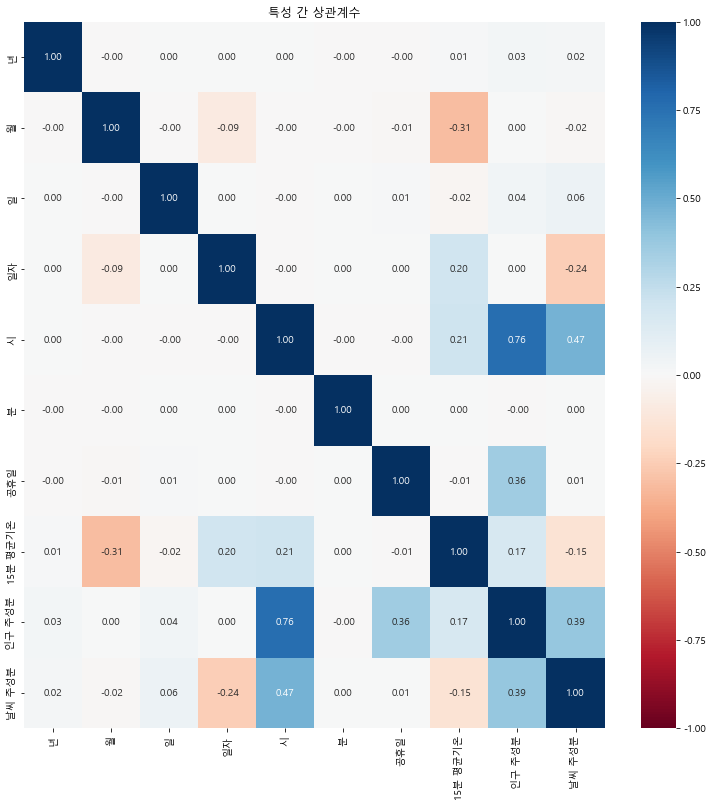

In [48]:
print("특성 간 다중공선성 확인")
featureKr=["년",'월','일','일자','시','분','공휴일','15분 평균기온','인구 주성분','날씨 주성분']
visDf=pd.DataFrame(df[features].drop('구분', axis=1).corr())
visDf.columns=featureKr
visDf.index=featureKr
plt.figure(figsize=(13,13))
sns.heatmap(visDf, annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='RdBu')
plt.title("특성 간 상관계수")
plt.savefig(eda_path+"특성_다중공선성.png")
plt.show()

사용변수(날씨, 인구) 분포 및 범위 확인: 바이올린 플롯


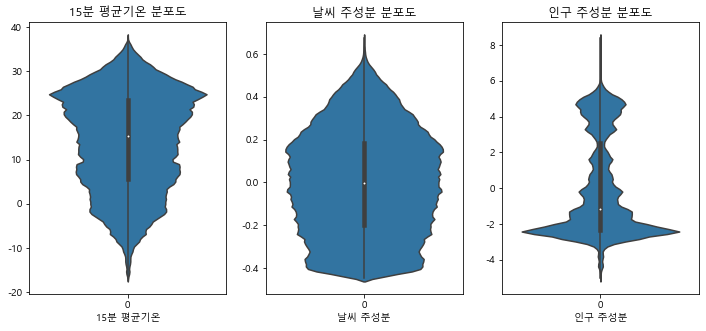

In [50]:
print("사용변수(날씨, 인구) 분포 및 범위 확인: 바이올린 플롯")
fig, ax = plt.subplots(1,3,figsize=(12,5))
checkCols=['ta_mean', 'weather_pc','강남구생활인구수_주성분']
krName=['15분 평균기온','날씨 주성분','인구 주성분']
c=0

for i,col in enumerate(checkCols):
    sns.violinplot(data=df[col], ax=ax[i])
    ax[i].set_xlabel(krName[c])
    ax[i].set_title(krName[c]+" 분포도")
    c+=1
    
plt.savefig(eda_path+"바이올린.png")
plt.show()


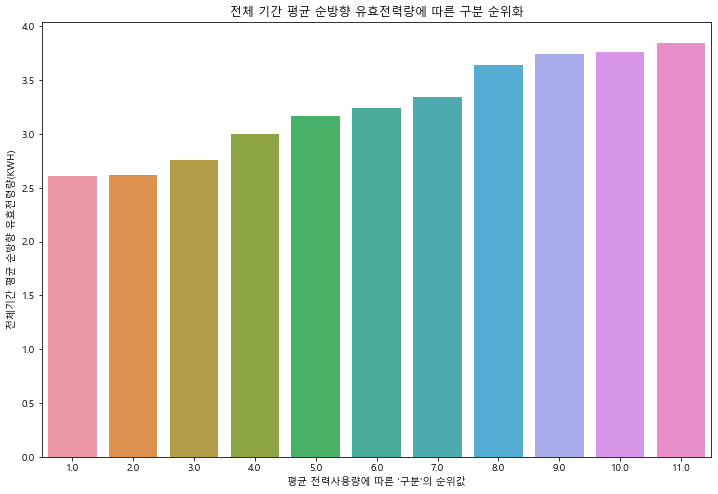

In [51]:

visDf=df.groupby('구분')[['순방향 유효전력량(KWH)']].mean().reset_index().iloc[:10]
plt.figure(figsize=(12,8))
sns.barplot(data=visDf, x='구분', y='순방향 유효전력량(KWH)')
plt.xlabel("평균 전력사용량에 따른 '구분'의 순위값")
plt.ylabel("전체기간 평균 순방향 유효전령량(KWH)")
plt.title("전체 기간 평균 순방향 유효전력량에 따른 구분 순위화(10순위)")
plt.savefig(eda_path+"구분_순위화.png")
plt.show()

## 최종 모델 학습

In [59]:
print("최종 사용변수 개수: ",len(features))
print("최종 사용 변수 목록: ", features)
print("최종 학습데이터(X) shape",X.shape)
print("최종 학습데이터(y) shape",y.shape)
print("누락구간 데이터(val) shape", val.shape)

최종 사용변수 개수:  11
최종 사용 변수 목록:  ['구분', 'year', 'month', 'day', 'dayofyear', 'hour', 'minute', 'weekday', 'ta_mean', '강남구생활인구수_주성분', 'weather_pc']
최종 학습데이터(X) shape (30806863, 11)
최종 학습데이터(y) shape (30806863,)
누락구간 데이터(val) shape (245700, 11)


In [61]:
print("모델 불러오기 위한 파일명 설정")
lgbmNames = ['lgbm1','lgbm2','lgbm3']
xgbNames = ['xgb1','xgb2','xgb3']
linearNames = ['lr','sgd','lsvr']
path="./모델링/"

모델 불러오기 위한 파일명 설정


In [63]:
print("구축된 9개 모델의 파라미터 확인")
nameList=[lgbmNames, xgbNames,linearNames]
for l in nameList:
    for modelName in l:
        with open(path+modelName+".pkl", 'rb') as f:
            model=pickle.load(f)
        print(modelName," 파라미터 확인")
        print(model.get_params())
        print(end='\n\n')
del nameList

구축된 9개 모델의 파라미터 확인
lgbm1  파라미터 확인
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.69, 'importance_type': 'split', 'learning_rate': 0.135, 'max_depth': -1, 'min_child_samples': 14, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 586, 'n_jobs': -1, 'num_leaves': 96, 'objective': None, 'random_state': 19, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 233604, 'subsample_freq': 0, 'verbose': 1}


lgbm2  파라미터 확인
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.51, 'importance_type': 'split', 'learning_rate': 0.219, 'max_depth': -1, 'min_child_samples': 18, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1065, 'n_jobs': -1, 'num_leaves': 93, 'objective': None, 'random_state': 19, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 236791, 'subsample_freq': 0, 'verbose': 1}


lgbm3  파라미터 확인
{'boosting_type': 'gbdt', 'class_weig

In [75]:
print("결과 해석을 위한 피쳐분석 담아둘 자료")
featureAnalysis={}

결과 해석을 위한 피쳐분석 담아둘 자료


In [91]:
print("lgbm모델을 전체 데이터로 재훈련 및 최종 모델로 저장")
for modelName in lgbmNames:
    fileDir=f"{path}{modelName}.pkl"
    with open(fileDir, 'rb') as f:
        model=pickle.load(f)
        print(modelName, "로드 완료")
    start=datetime.datetime.now()
    model.fit(X,y)
    print(modelName, "학습 완료")
    print("학습 시간: ", datetime.datetime.now()-start)
    with open(f"./최종모델/{modelName}.pkl", 'wb') as f:
        pickle.dump(model,f)
        print(modelName, "저장완료")
    featureAnalysis[modelName]=model.feature_importances_
    print("피쳐분석 저장완료")
    print(end="\n\n")

lgbm모델을 전체 데이터로 재훈련 및 최종 모델로 저장
lgbm1 로드 완료
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.306059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 30806863, number of used features: 11
[LightGBM] [Info] Start training from score 12.627734
lgbm1 학습 완료
학습 시간:  0:02:37.936588
lgbm1 저장완료
피쳐분석 저장완료


lgbm2 로드 완료
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 30806863, number of used features: 11
[LightGBM] [Info] Start training from score 12.627734
lgbm2 학습 완료
학습 시간:  0:04:08.642957
lgbm2 저장완료
피쳐분석 저장완료


lg

In [96]:
print("linear모델을 전체 데이터로 재훈련 및 최종 모델로 저장")
for modelName in linearNames:
    fileDir=f"{path}{modelName}.pkl"
    with open(fileDir, 'rb') as f:
        model=pickle.load(f)
        print(modelName, "로드 완료")
    print(modelName,"파라미터 확인")
    print(model.get_params())
    start=datetime.datetime.now()
    model.fit(X,y)
    print(modelName, "학습 완료")
    print("학습 시간: ", datetime.datetime.now()-start)
    with open(f"./최종모델/{modelName}.pkl", 'wb') as f:
        pickle.dump(model,f)
        print(modelName, "저장완료")
    featureAnalysis[modelName]=model.coef_
    print("피쳐분석 저장완료")
    print(end="\n\n")

linear모델을 전체 데이터로 재훈련 및 최종 모델로 저장
lr 로드 완료
lr 파라미터 확인
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
lr 학습 완료
학습 시간:  0:00:11.577298
lr 저장완료
피쳐분석 저장완료


sgd 로드 완료
sgd 파라미터 확인
{'alpha': 0.0001, 'average': False, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.125, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 1, 'warm_start': False}
-- Epoch 1
Norm: 32.65, NNZs: 11, Bias: -13.149277, T: 27726176, Avg. loss: 25.214278
Total training time: 15.98 seconds.
-- Epoch 2
Norm: 32.66, NNZs: 11, Bias: -12.821960, T: 55452352, Avg. loss: 25.167737
Total training time: 34.73 seconds.
-- Epoch 3
Norm: 32.56, NNZs: 11, Bias: -13.330435, T: 83178528, Avg. loss: 25.155210
Total training time: 54.04 seconds.
-- Epoch 4
Norm: 32.39, N

In [97]:
print("xgb모델을 전체 데이터로 재훈련 및 최종 모델로 저장")
for modelName in xgbNames:
    fileDir=f"{path}{modelName}.pkl"
    with open(fileDir, 'rb') as f:
        model=pickle.load(f)
        print(modelName, "로드 완료")
    print(modelName,"파라미터 확인")
    print(model.get_params())
    start=datetime.datetime.now()
    model.fit(X,y)
    print(modelName, "학습 완료")
    print("학습 시간: ", datetime.datetime.now()-start)
    with open(f"./최종모델/{modelName}.pkl", 'wb') as f:
        pickle.dump(model,f)
        print(modelName, "저장완료")
    featureAnalysis[modelName]=model.feature_importances_
    print("피쳐분석 저장완료")
    print(end="\n\n")

xgb모델을 전체 데이터로 재훈련 및 최종 모델로 저장
xgb1 로드 완료
xgb1 파라미터 확인
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.88, 'colsample_bynode': 0.54, 'colsample_bytree': 0.55, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mae', 'feature_types': None, 'gamma': 2.87, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.28, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 284, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 19, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': 1}
xgb1 학습 완료
학습 시간:  0:14:16.369244
xgb1 저장완료
피쳐분석 저장완료


x

In [98]:
print("훈련완료된 베이스 모델을 가지고 최종 예측값 산출")
path="./최종모델/"
modelNames = ['lgbm1','lgbm2','lgbm3','lr','lsvr','sgd','xgb1','xgb2','xgb3']
print("메타모델이 사용할 예측 값의 순서", modelNames)

base_predDf =pd.DataFrame()
for modelName in modelNames:
    with open(path+modelName+".pkl", 'rb') as f:
        model=pickle.load(f)
        print(modelName," 로드 완료")
    base_predDf[modelName]=model.predict(val)
    print(modelName, " 예측 및 저장 완료")
    print(end="\n\n")
base_predDf.to_csv("./최종모델/mlp사용데이터.csv")

훈련완료된 베이스 모델을 가지고 최종 예측값 산출
메타모델이 사용할 예측 값의 순서 ['lgbm1', 'lgbm2', 'lgbm3', 'lr', 'lsvr', 'sgd', 'xgb1', 'xgb2', 'xgb3']
lgbm1  로드 완료
lgbm1  예측 및 저장 완료


lgbm2  로드 완료
lgbm2  예측 및 저장 완료


lgbm3  로드 완료
lgbm3  예측 및 저장 완료


lr  로드 완료
lr  예측 및 저장 완료


lsvr  로드 완료
lsvr  예측 및 저장 완료


sgd  로드 완료
sgd  예측 및 저장 완료


xgb1  로드 완료
xgb1  예측 및 저장 완료


xgb2  로드 완료
xgb2  예측 및 저장 완료


xgb3  로드 완료
xgb3  예측 및 저장 완료




In [99]:
print("훈련완료된 메타 모델을 가지고 최종 예측 수행")
print("mlp 모델의 예측에 사용될 데이터의 크기 및 형태: ", base_predDf.shape)
display(base_predDf.head())
with open(path+"mlp.pkl",'rb') as f:
    model=pickle.load(f)
    print("mlp 로드 완료")
print("mlp 파라미터 확인")
print(model.get_params())
y_pred=model.predict(base_predDf.values)
y_pred_final=[round(pr,5) if pr > 0 else 0 for pr in y_pred]
print("최종 누락구간 예측 완료")

훈련완료된 메타 모델을 가지고 최종 예측 수행
mlp 모델의 예측에 사용될 데이터의 크기 및 형태:  (245700, 9)


,lgbm1,lgbm2,lgbm3,lr,lsvr,sgd,xgb1,xgb2,xgb3
0,1.605,1.149,1.215,9.809,8.533,9.079,5.088,5.468,2.877
1,1.581,1.246,1.282,9.797,8.506,9.040,4.962,5.267,2.792
2,1.497,1.226,1.262,9.785,8.479,9.002,5.075,5.225,2.765
3,1.303,1.141,1.184,9.712,8.474,9.008,5.293,5.676,2.929
4,1.364,1.163,1.214,9.701,8.447,8.969,5.179,5.356,2.979


mlp 로드 완료
mlp 파라미터 확인
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (128,), 'learning_rate': 'constant', 'learning_rate_init': 0.15, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 5, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 19, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': True, 'warm_start': False}
최종 누락구간 예측 완료


In [103]:
print("제출용 데이터에 삽입")
submitDf=pd.read_excel("과제 제출물(빅데이터분석과제4_홍길동).xlsx")
submitDf['순방향 유효전력량(KWH)'] = y_pred_final
submitDf.to_excel("과제 제출물(빅데이터분석과제4_안태환).xlsx", index=False)
print("제출용 데이터 저장 완료")

제출용 데이터에 삽입
제출용 데이터 저장 완료


In [109]:
print("최종예측값의 길이",len(y_pred_final))
print("최종예측값 앞 5개: ", y_pred_final[:5])
print("최종예측값 뒤 5개: ", y_pred_final[-5:])

최종예측값의 길이 245700
최종예측값 앞 5개:  [0.08661, 0.21646, 0.15818, 0, 0.08498]
최종예측값 뒤 5개:  [9.12774, 8.86897, 8.59917, 8.53076, 8.50582]


In [105]:
test1 = pd.read_excel("과제 제출물(빅데이터분석과제4_홍길동).xlsx")
test1

,구분,검침일,순방향 유효전력량(KWH)
0,A0001,2021-12-20 03:15,NaN
1,A0001,2021-12-20 03:30,NaN
2,A0001,2021-12-20 03:45,NaN
3,A0001,2021-12-20 04:00,NaN
4,A0001,2021-12-20 04:15,NaN
...,...,...,...
245695,A0300,2023-08-24 23:00,NaN
245696,A0300,2023-08-24 23:15,NaN
245697,A0300,2023-08-24 23:30,NaN
245698,A0300,2023-08-24 23:45,NaN


In [106]:
test2 = pd.read_excel("과제 제출물(빅데이터분석과제4_안태환).xlsx")
test2

,구분,검침일,순방향 유효전력량(KWH)
0,A0001,2021-12-20 03:15,0.087
1,A0001,2021-12-20 03:30,0.216
2,A0001,2021-12-20 03:45,0.158
3,A0001,2021-12-20 04:00,0.000
4,A0001,2021-12-20 04:15,0.085
...,...,...,...
245695,A0300,2023-08-24 23:00,9.128
245696,A0300,2023-08-24 23:15,8.869
245697,A0300,2023-08-24 23:30,8.599
245698,A0300,2023-08-24 23:45,8.531


In [101]:
print("결과해석용 자료 다운로드")
print("피쳐분석")
featureDf=pd.DataFrame(featureAnalysis, index=features).T
featureDf.to_csv("베이스모델피쳐분석.csv")

결과해석용 자료 다운로드
피쳐분석


In [111]:
test3=pd.read_csv("베이스모델피쳐분석.csv",index_col=0)
test3.head()

,구분,year,month,day,dayofyear,hour,minute,weekday,ta_mean,강남구생활인구수_주성분,weather_pc
lgbm1,16278.000,3148.000,2569.000,1710.000,6311.000,7765.000,877.000,2992.000,5370.000,6564.000,2086.000
lgbm2,17349.000,4320.000,5373.000,6179.000,13355.000,11262.000,2234.000,5509.000,11447.000,12257.000,8695.000
lgbm3,15740.000,3227.000,3848.000,4080.000,9668.000,8496.000,1485.000,3984.000,7907.000,8443.000,4854.000
lr,23.835,0.219,6.781,0.453,0.086,4.261,-0.009,0.561,-1.003,20.519,0.988
sgd,23.860,0.475,6.677,0.457,0.108,4.419,-0.121,0.288,-1.014,20.319,0.866


## 결과해석

최종 누락구간 예측값과 전체 데이터의 유효전력량 간 분포 비교


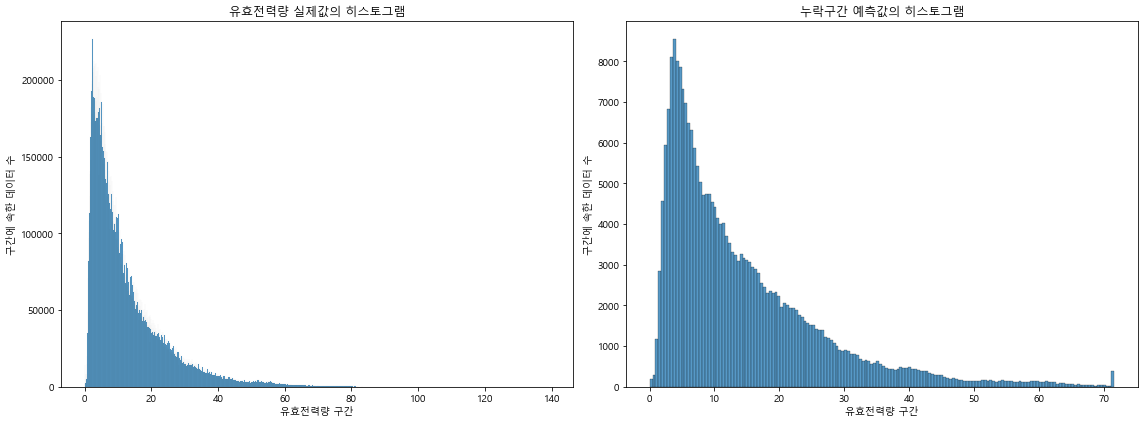

In [102]:
print("최종 누락구간 예측값과 전체 데이터의 유효전력량 간 분포 비교")
fig,ax=plt.subplots(1,2,figsize=(16,6))
sns.histplot(df['순방향 유효전력량(KWH)'].values, ax=ax[0])
ax[0].set_title("유효전력량 실제값의 히스토그램")
ax[0].set_xlabel("유효전력량 구간")
ax[0].set_ylabel("구간에 속한 데이터 수")
sns.histplot(y_pred_final, ax=ax[1])
ax[1].set_title("누락구간 예측값의 히스토그램")
ax[1].set_xlabel("유효전력량 구간")
ax[1].set_ylabel("구간에 속한 데이터 수")
plt.tight_layout()
plt.savefig("./시각화/실제및예측_히스토그램.png")
plt.show()

In [4]:
print("특성 중요도 및 회귀 계수 확인하기")
resDf = pd.read_csv("베이스모델피쳐분석.csv", index_col=0)
resDf.columns = ['구분','년','월','일','dayofyear','시','분','요일','15분_평균기온','인구주성분','날씨주성분']
# 컬럼 순서 변경: 인구주성분 <-> 날씨주성분
resDf=resDf[['구분','년','월','일','dayofyear','시','분','요일','15분_평균기온','날씨주성분','인구주성분']]
# 인덱스 순서 변경: lgbm, xgb, 선형 순으로
resDf=resDf.loc[['lgbm1','lgbm2','lgbm3','xgb1','xgb2','xgb3','lr','sgd','lsvr']]
# 축변환
resDf=resDf.T
resDf

특성 중요도 및 회귀 계수 확인하기


,lgbm1,lgbm2,lgbm3,xgb1,xgb2,xgb3,lr,sgd,lsvr
구분,16278.0,17349.0,15740.0,0.462160,0.384876,0.378722,23.834947,23.860288,17.126277
년,3148.0,4320.0,3227.0,0.013283,0.014515,0.025025,0.218796,0.474929,0.132278
월,2569.0,5373.0,3848.0,0.076856,0.071738,0.122164,6.780622,6.676661,4.821267
일,1710.0,6179.0,4080.0,0.003669,0.004321,0.002949,0.452588,0.457313,0.221249
dayofyear,6311.0,13355.0,9668.0,0.010065,0.022539,0.017180,0.085903,0.108343,0.031945
시,7765.0,11262.0,8496.0,0.121922,0.197846,0.050747,4.260598,4.418620,3.415987
분,877.0,2234.0,1485.0,0.001478,0.003952,0.004322,-0.009307,-0.120996,-0.074282
요일,2992.0,5509.0,3984.0,0.041044,0.022350,0.021874,0.560703,0.288118,0.622929
15분_평균기온,5370.0,11447.0,7907.0,0.062694,0.067729,0.051152,-1.002719,-1.014259,-1.114922
날씨주성분,2086.0,8695.0,4854.0,0.009055,0.054336,0.006374,0.987632,0.866390,0.895362


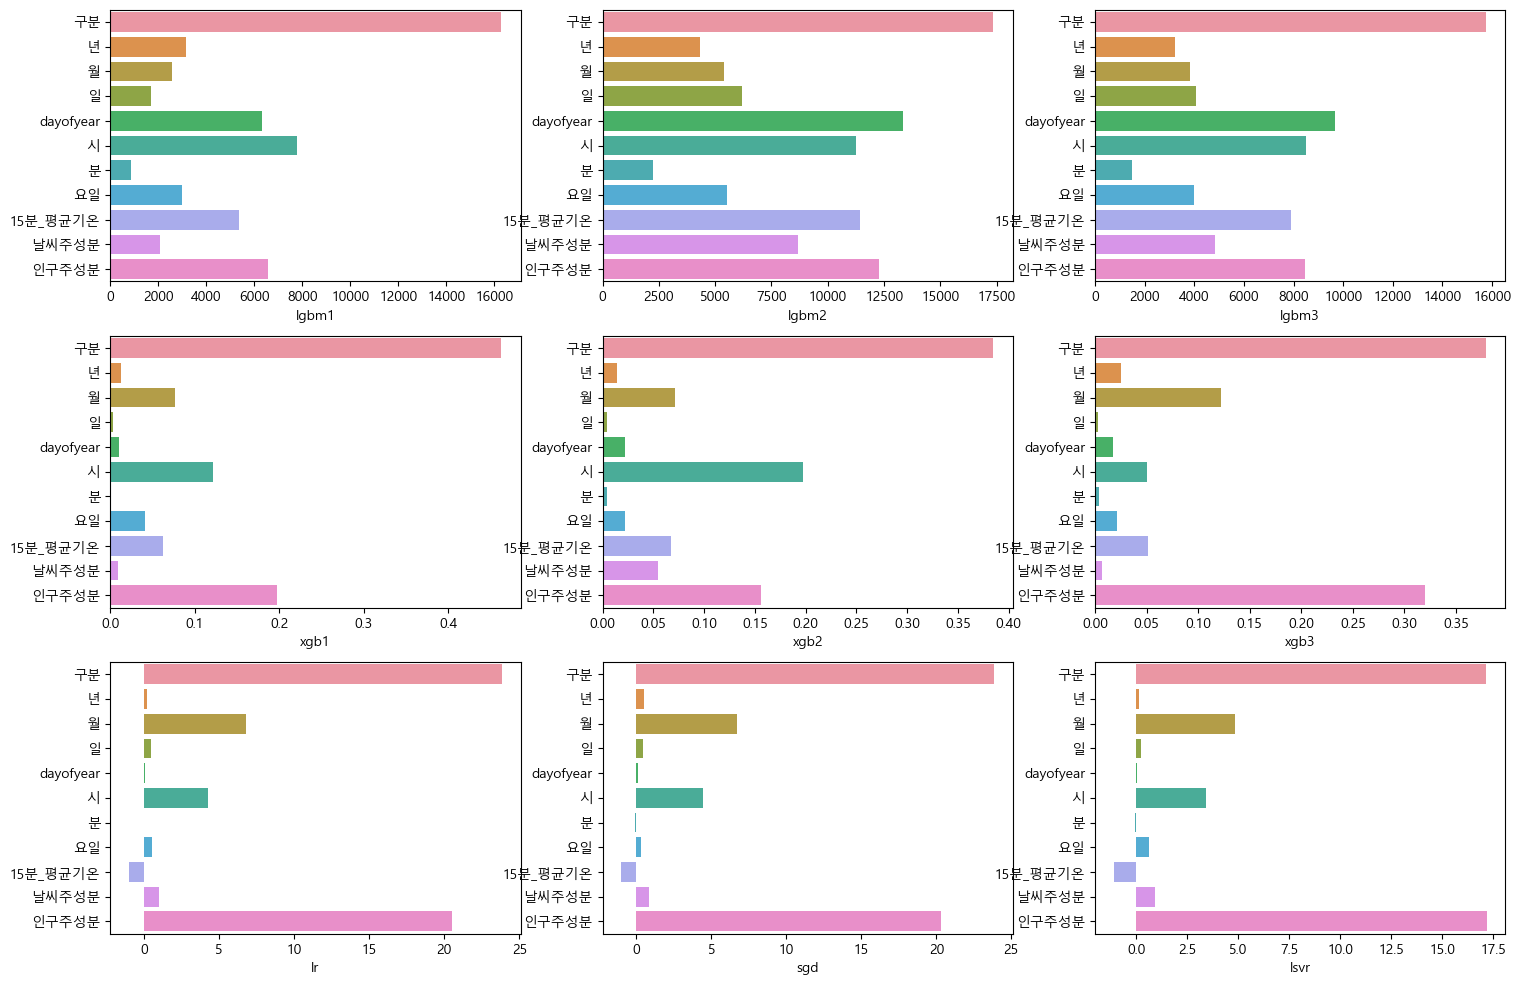

In [5]:
fig, ax = plt.subplots(3,3,figsize=(18,12))
col={n : col for n,col in enumerate(resDf.columns)}
n=0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.barplot(x=resDf[col[n]],y=resDf.index, ax=ax[i,j])
        n+=1
plt.show()

In [6]:
print("알고리즘 별로 평균내어 시각화")
resDf1=pd.DataFrame(
    {
        'lgbm': resDf.iloc[:,:3].mean(axis=1), 'xgb': resDf.iloc[:,3:6].mean(axis=1), 'linear': resDf.iloc[:,6:].mean(axis=1)
    },
    index=resDf.index
)
resDf1

알고리즘 별로 평균내어 시각화


,lgbm,xgb,linear
구분,16455.666667,0.408586,21.607170
년,3565.000000,0.017608,0.275335
월,3930.000000,0.090252,6.092850
일,3989.666667,0.003646,0.377050
dayofyear,9778.000000,0.016595,0.075397
시,9174.333333,0.123505,4.031735
분,1532.000000,0.003251,-0.068195
요일,4161.666667,0.028423,0.490584
15분_평균기온,8241.333333,0.060525,-1.043966
날씨주성분,5211.666667,0.023255,0.916461


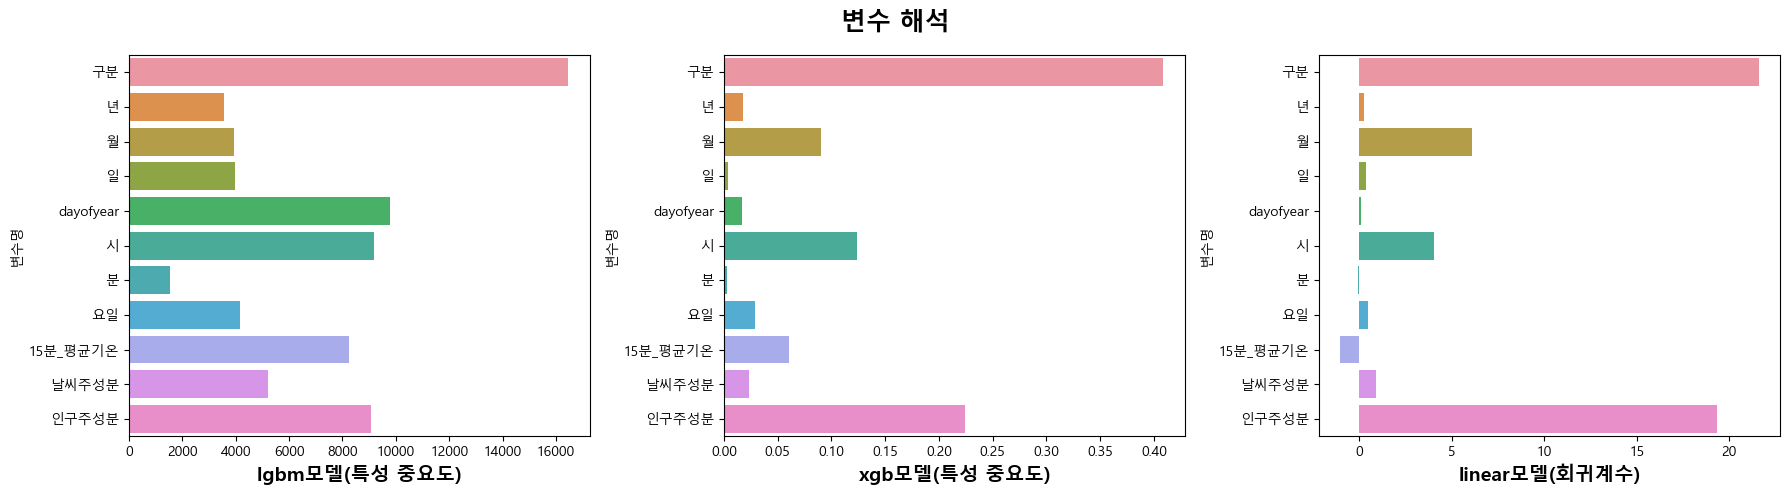

In [7]:
fig,ax = plt.subplots(1,3, figsize=(18,5))
col={n : col for n,col in enumerate(resDf1.columns)}

for k,v in col.items():
    sns.barplot(x=resDf1[v].values, y=resDf1.index, ax=ax[k])
    if k<2:
        ax[k].set_xlabel(f"{v}모델(특성 중요도)", fontweight='bold', fontsize=14)
    else:
        ax[k].set_xlabel(f"{v}모델(회귀계수)", fontweight='bold', fontsize=14)
    ax[k].set_ylabel("변수명")
        
fig.suptitle("변수 해석", fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

# 모델링 과정 코드
- 아래에서부터는 실제 모델 탐색 과정 코드입니다. 반출을 위하여 필요한 셀만 추출하였습니다.

In [7]:
class prepareData:
    """전력데이터, 기상데이터, 인구(주성분)데이터를 입력받아 통합 데이터로 만들고, 시간관련 정보를 전처리하는 클래스"""
    def __init__(self,eleDf, weatherDf=None, popDf = None):
        self.eleDf = eleDf.rename(columns={'정전여부': 'isBlack'})
        self.weatherDf = weatherDf
        self.popDf = popDf
        self.idx=self.eleDf.index
        self.naIdx=self.eleDf[self.eleDf['순방향 유효전력량(KWH)'].isna()].index
        
        self.df=None
        self.mappingInfo={}
        
    def categorizeIsBlack(self):
        """정전여부를 라벨링"""
        self.eleDf['isBlack']=self.eleDf['isBlack'].apply(lambda x: 1 if x=='정전발생' else 0)
        
    def mergeDf(self):
        """eleDf와 선택에 따라서 기상데이터나 인구데이터를 통합하여 self.df에 저장하는 코드"""
        self.categorizeIsBlack()
        ele_copy=self.eleDf.copy()
        
        if self.weatherDf is None and self.popDf is None: # eleDf
            self.df=ele_copy
            
        elif self.weatherDf is not None and self.popDf is None: # eleDf+weatherDf
            weahter_copy=self.weatherDf.copy()
            weahter_copy['일시']=weahter_copy['일시'].apply(lambda x: x[:-3]) # weatherDf가 초단위 까지 표기되어있음(분단위로 머지해야함)
            self.df=ele_copy.merge(weahter_copy, how='left', left_on='검침일', right_on='일시').drop('일시',axis=1)
        
        elif self.weatherDf is None and self.popDf is not None: # eleDf+popDf
            pop_copy=self.popDf.copy()
            ele_copy['기준시점']=ele_copy['검침일'].apply(lambda x: x[:-3])
            pop_copy['기준시점']=pop_copy['기준시점'].apply(lambda x: x[:-6]) # poppcaDf가 초단위 까지 표기되어있음(시단위로 머지해야함)
            self.df=ele_copy.merge(pop_copy, how='left', left_on='기준시점', right_on='기준시점').drop(['기준시점','시간대구분','기준일ID'],axis=1)
            # 생활인구 데이터는 시간단위 이기 때문에 24:00 정보가 없으므로 앞의 값을 이용하여 결측치 채워주기
            
        elif self.weatherDf is not None and self.popDf is not None: # eleDf+weatherDf+popDf
            weahter_copy=self.weatherDf.copy()
            pop_copy=self.popDf.copy()
            weahter_copy['일시']=weahter_copy['일시'].apply(lambda x: x[:-3])
            ele_copy['기준시점']=ele_copy['검침일'].apply(lambda x: x[:-3])
            pop_copy['기준시점']=pop_copy['기준시점'].apply(lambda x: x[:-6])
            
            self.df=ele_copy.merge(weahter_copy, how='left', left_on='검침일', right_on='일시').merge(pop_copy, how='left', left_on='기준시점', right_on='기준시점').drop(['기준시점','시간대구분','기준일ID','일시'],axis=1)

    # 0611 변경 코드
    def fillNan(self):
        """기상 및 인구데이터와의 매핑 과정에서 발생한 결측치를 그 이전 값으로 대치(15분 단위로 끊기지 않는 분단위의 존재로 인하여 생겨난 NA들)"""
        self.df=self.df.apply(lambda col: col.fillna(method='ffill') if col.name != '순방향 유효전력량(KWH)' else col)
    
    def generateTimeFeatures(self):
        """전력데이터에서 시계열 정보를 파생하는 코드"""
        import datetime
        def decomposeStrTime(datetimeStr, whichTime):
            if whichTime=='year':
                return datetimeStr[0:4]
            elif whichTime=='month':
                return datetimeStr[5:7]
            elif whichTime=='day':
                return datetimeStr[8:10]
            elif whichTime=='hour':
                return datetimeStr[-5:-3]
            elif whichTime=='minute':
                return datetimeStr[-2:]
            elif whichTime=='date':
                return datetimeStr[:10]
        self.df['year']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'year'))
        self.df['month']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'month'))
        self.df['day']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'day'))
        self.df['hour']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'hour'))
        self.df['minute']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'minute'))
        self.df['weekday']=pd.to_datetime(self.df['검침일'].apply(lambda x: decomposeStrTime(x,'date'))).apply(lambda x: x.weekday())

    def rankFeatureMapping(self):
        """고객,월,일,시간,요일 별로 평균 KWH가 높은 순서대로 높은 값을 부여하는 매핑"""
        mappingColumnList=['구분','month','day','hour','weekday']
        for mappingCol in mappingColumnList:
            mapping=self.df.groupby(mappingCol)['순방향 유효전력량(KWH)'].mean().rank().to_dict()
            self.df[mappingCol] = self.df[mappingCol].apply(lambda x: mapping[x])
            self.mappingInfo[mappingCol]=mapping
    # 추가 0611
    def removeFeatures(self, featureNamesList=None):
        return self.df.drop(featureNamesList, axis=1)
    
    def getDf(self):
        return self.df
    def getMappingInfo(self):
        return self.mappingInfo

In [ ]:
modelsDict={}
modelsDict['XGBreg_gbtree_N333_G5']= XGBRegressor(booster='gbtree', n_estimators=333, eta=0.3, eval_metric='mae', gamma=5)
modelsDict['XGBreg_gbtree_N333_G33']= XGBRegressor(booster='gbtree', n_estimators=333, eta=0.3, eval_metric='mae', gamma=33)
slt=selectModels(X_train, y_train, modelsDict)
slt.procSelection()
# XGBreg_gbtree_N333_G5
# {'fit_time': array([646.02869344, 529.6065414 , 589.28913832]), 'score_time': array([6.93701935, 7.61028194, 6.70243192]), 'test_r2': array([0.88344726, 0.88335574, 0.88401967]), 'test_neg_mean_absolute_error': array([-2.52203987, -2.52784904, -2.52043255]), 'test_neg_root_mean_squared_error': array([-3.99895723, -4.00065901, -3.99174456])}

In [171]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
modelsDict={}
modelsDict['lgbm_col0.1']=LGBMRegressor(n_estimators=333, num_leaves=77 ,colsample_bytree=0.1)
modelsDict['lgbm_col1.0']=LGBMRegressor(n_estimators=333, num_leaves=77 ,colsample_bytree=1.0)
modelsDict['linear']=LinearRegression()
slt=selectModels(X_train, y_train, modelsDict)
slt.procSelection()

lgbm_col0.1
{'r2': 0.699, 'mae': 4.357, 'mape': 12105064488020.65}
******************************************************************************************************************************************************
lgbm_col1.0
{'r2': 0.888, 'mae': 2.628, 'mape': 6391611510772.188}
******************************************************************************************************************************************************
linear
{'r2': 0.594, 'mae': 5.201, 'mape': 10831333461917.014}
******************************************************************************************************************************************************


In [176]:
modelsDict={}
modelsDict['lgbm_col3']=LGBMRegressor(n_estimators=333, num_leaves=77 ,colsample_bytree=0.3)
modelsDict['lgbm_col5']=LGBMRegressor(n_estimators=333, num_leaves=77 ,colsample_bytree=0.5)
modelsDict['lgbm_col7']=LGBMRegressor(n_estimators=333, num_leaves=77 ,colsample_bytree=0.7)
slt=selectModels(X_train, y_train, modelsDict)
slt.procSelection()

lgbm_col3
{'r2': 0.849, 'mae': 2.984}
******************************************************************************************************************************************************
lgbm_col5
{'r2': 0.881, 'mae': 2.68}
******************************************************************************************************************************************************
lgbm_col7
{'r2': 0.887, 'mae': 2.617}
******************************************************************************************************************************************************


In [180]:
modelsDict={}
modelsDict['ADAreg_N3']=AdaBoostRegressor(n_estimators=3, random_state=42)
slt=selectModels(X_train, y_train, modelsDict)
slt.procSelection()

ADAreg_N3
{'r2': 0.622, 'mae': 5.047}
******************************************************************************************************************************************************


In [196]:
modelsDict={}
modelsDict['ADAreg_N7']=AdaBoostRegressor(n_estimators=7, random_state=42)
modelsDict['ADAreg_N11']=AdaBoostRegressor(n_estimators=11, random_state=42)
modelsDict['ADAreg_N21']=AdaBoostRegressor(n_estimators=21, random_state=42)
slt=selectModels(X_train_sample, y_train_sample, modelsDict)
slt.procSelection()

ADAreg_N7
{'r2': 0.636, 'mae': 5.04}
******************************************************************************************************************************************************
ADAreg_N11
{'r2': 0.625, 'mae': 5.223}
******************************************************************************************************************************************************
ADAreg_N21
{'r2': 0.537, 'mae': 6.189}
******************************************************************************************************************************************************


In [204]:
modelsDict={}
modelsDict['ADAreg_N7_LR7']=AdaBoostRegressor(n_estimators=7, random_state=42, learning_rate=0.7)
modelsDict['ADAreg_N7_LR3']=AdaBoostRegressor(n_estimators=7, random_state=42, learning_rate=0.3)
slt=selectModels(X_train_sample, y_train_sample, modelsDict)
slt.procSelection()

ADAreg_N7_LR7
{'r2': 0.651, 'mae': 4.91}
******************************************************************************************************************************************************
ADAreg_N7_LR3
{'r2': 0.644, 'mae': 4.898}
******************************************************************************************************************************************************


In [205]:
modelsDict={}
modelsDict['ADAreg_N9_LR5']=AdaBoostRegressor(n_estimators=9, random_state=42, learning_rate=0.5)
modelsDict['ADAreg_N9_LR1']=AdaBoostRegressor(n_estimators=9, random_state=42, learning_rate=0.1)
slt=selectModels(X_train_sample, y_train_sample, modelsDict)
slt.procSelection()

ADAreg_N9_LR5
{'r2': 0.651, 'mae': 4.871}
******************************************************************************************************************************************************
ADAreg_N9_LR1
{'r2': 0.616, 'mae': 4.985}
******************************************************************************************************************************************************


In [201]:
modelsDict={}
modelsDict['GBreg_N3']=GradientBoostingRegressor(n_estimators=5, random_state=42)
# modelsDict['GBreg_N33']=GradientBoostingRegressor(n_estimators=55, random_state=42)
# modelsDict['GBreg_N333']=GradientBoostingRegressor(n_estimators=100, random_state=42)
modelsDict['GBreg_N100']=GradientBoostingRegressor(n_estimators=100, random_state=42,verbose=1)
slt=selectModels(X_train_sample, y_train_sample, modelsDict)
slt.procSelection()

GBreg_N3
{'r2': 0.403, 'mae': 6.525}
******************************************************************************************************************************************************
      Iter       Train Loss   Remaining Time 
         1         121.5434            6.52m
         2         108.8272            6.39m
         3          98.2485            6.29m
         4          89.3244            6.17m
         5          81.8780            6.11m
         6          75.5690            6.05m
         7          70.2596            5.96m
         8          65.8208            5.92m
         9          61.8409            5.86m
        10          58.5191            5.78m
        20          41.3080            5.15m
        30          35.8335            4.47m
        40          33.5199            3.81m
        50          32.4236            3.15m
        60          31.8955            2.50m
        70          31.5887            1.87m
        80          31.3623            1.25m
 

In [213]:
modelsDict={}
modelsDict['MLRreg']=MLPRegressor(
    early_stopping=True, hidden_layer_sizes=(128,32,2), learning_rate_init= 0.01, max_iter=1000, n_iter_no_change = 5,
    tol=0.01, verbose=True
)
slt=selectModels(X_train_sample.values, y_train_sample.valuesb, modelsDict)
slt.procSelection()

Iteration 1, loss = 74.51903133
Validation score: -0.000027
Iteration 2, loss = 68.53489821
Validation score: -0.000002
Iteration 3, loss = 37.41230674
Validation score: 0.696186
Iteration 4, loss = 18.31351886
Validation score: 0.746768
Iteration 5, loss = 17.30549311
Validation score: 0.755508
Iteration 6, loss = 16.94938297
Validation score: 0.760699
Iteration 7, loss = 16.80075764
Validation score: 0.759143
Iteration 8, loss = 16.73518216
Validation score: 0.742437
Iteration 9, loss = 16.63658817
Validation score: 0.760273
Iteration 10, loss = 16.58959796
Validation score: 0.764200
Validation score did not improve more than tol=0.010000 for 5 consecutive epochs. Stopping.
MLRreg
{'r2': 0.765, 'mae': 3.64}
******************************************************************************************************************************************************


In [174]:
from sklearn.svm import LinearSVR
LinearSVR().get_params()
modelsDict={}
modelsDict['LSVR_default']=LinearSVR(C=1.0, max_iter=100, epsilon=0.0, verbose=1)
# modelsDict['LSVR_soft']=LinearSVR(C=0.1, max_iter=3000, epsilon=0.0, verbose=1)
# modelsDict['LSVR_medium']=LinearSVR(C=10.0, max_iter=3000, epsilon=0.0, verbose=1)
# modelsDict['LSVR_hard']=LinearSVR(C=1000.0, max_iter=3000, epsilon=0.0, verbose=1)
slt=selectModels(X_train, y_train, modelsDict)
slt.procSelection()

[LibLinear]LSVR_default
{'r2': 0.542, 'mae': 4.891}
******************************************************************************************************************************************************


In [218]:
modelsDict={}
modelsDict['SVR_default']=SVR(kernel='linear' ,C=1.0, max_iter=100, epsilon=0.0, verbose=1)
modelsDict['SVR_default']=SVR(kernel='poly', degree=3 ,C=1.0, max_iter=100, epsilon=0.0, verbose=1)

slt=selectModels(X_train_sample, y_train_sample, modelsDict)
slt.procSelection()

[LibSVM]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR_default
{'r2': -1.577, 'mae': 16.345}
******************************************************************************************************************************************************


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
estimators=[(n,m) for n,m in modelsDict.items()]
final_lsvr=LinearSVR()
cv=KFold(n_splits=3, shufle=True)

stack_model=StackingRegressor(estimators=estimators, final_estimator=final_lsvr, cv=cv, verbose=1)
X_tr, x_tt, y_tr, y_tt = train_test_split(X_train, y_train, train_size=0.8, shuffle=True, random_state=42)
stack_model.fit(X_tr, y_tr)
y_pr=stack_model.predict(X_tt)
print('r2: ', r2_score(y_tt,y_pr))
print('mae: ', mean_absolute_error(y_tt,y_pr))

In [271]:
from lightgbm import LGBMRegressor
modelsDict={
    'lgbm1':LGBMRegressor(learning_rate=0.2, n_estimators=777, reg_lambda=0.1, num_leaves=31),
}
slt=selectModels(X_train, y_train, modelsDict)
slt.procSelection()
vis=pd.Series(modelsDict['lgbm1'].feature_importances_, index=xColList).sort_values(ascending=False)

lgbm1
{'r2': 0.912, 'mae': 2.323}
******************************************************************************************************************************************************


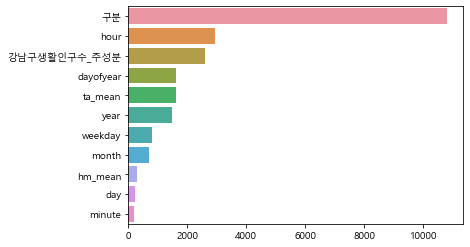

In [285]:
sns.barplot(x=vis.values, y=vis.index)
plt.show()

# 분석방향성 재설정
- 변수간 상관성 체크
- 대규모 데이터 셋을 다루기에 lgbm 을 제외한 다른 모델들은 시간효율성과 정확도, 그리고 설명력의 측면에서 부적합하다.
- 따라서 r2 스코어가 높았던 LGBM을 기본 모형으로 하되, 하이퍼 파라미터를 다양화하여 스태킹을 구성한다.
- 기본 모델은 LGBM으로만 구성하고, 최종 모델은 mlp Regression을 사용하자
- 기본 모델들의 feature_importances_ 와 r2 스코어 간 상관성을 분석하여 어떤 요인이 LGBM이 누락구간을 더 정확하게 예측하는지에 대한 설명을 제시한다.

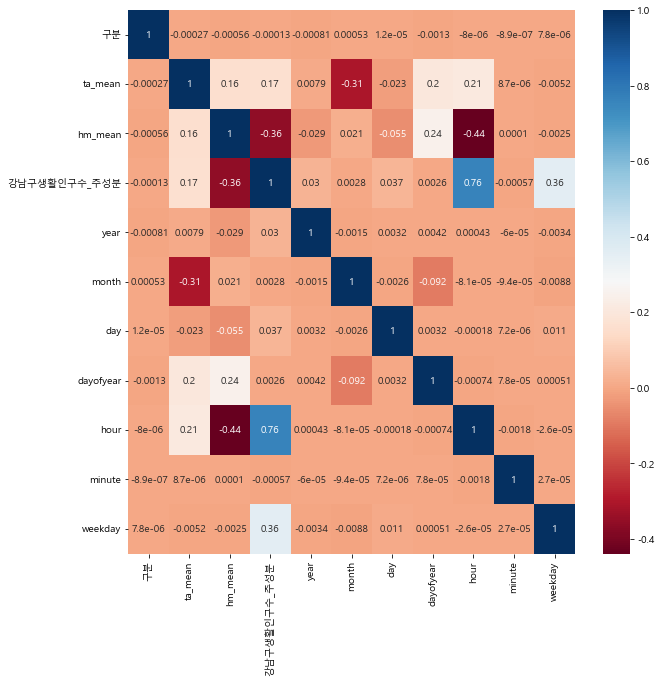

In [297]:
corrDf=pd.DataFrame(X_train,columns=xColList).corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrDf, annot=True, cmap='RdBu')
plt.show()

# 스태킹

In [28]:
pd.options.display.float_format = '{:.3f}'.format
prepare.df.describe()

,구분,순방향 유효전력량(KWH),ta_mean,rn_sum,ws_mean,hm_mean,강남구생활인구수_주성분,year,month,day,dayofyear,hour,weekday
count,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000,30806863.000
mean,150.776,12.628,14.157,0.041,1.195,62.216,-0.003,2022.002,6.480,16.154,182.950,13.261,3.991
std,86.552,11.716,11.012,0.398,0.821,21.420,2.767,0.818,3.455,8.954,105.376,7.243,1.999
min,1.000,0.000,-16.913,0.000,0.000,7.580,-5.034,2021.000,1.000,1.000,1.000,1.000,1.000
25%,76.000,4.490,5.627,0.000,0.567,45.740,-2.310,2021.000,3.000,9.000,91.000,8.000,2.000
50%,151.000,8.750,15.287,0.000,1.053,62.053,-1.145,2022.000,6.000,16.000,183.000,14.000,4.000
75%,226.000,16.920,23.473,0.000,1.673,79.507,2.499,2023.000,9.000,24.000,275.000,20.000,6.000
max,300.000,139.280,37.687,32.000,6.367,99.900,8.414,2023.000,12.000,31.000,365.000,25.000,7.000


In [47]:
display(pd.DataFrame(X, columns=features).head())
display(pd.DataFrame(val, columns=features).head())

,구분,year,month,day,dayofyear,hour,minute,weekday,ta_mean,강남구생활인구수_주성분,weather_pc
0,0.528,0.000,1.000,0.000,0.000,0.208,0.254,0.500,0.186,0.170,0.430
1,0.528,0.000,1.000,0.000,0.000,0.208,0.508,0.500,0.183,0.170,0.430
2,0.528,0.000,1.000,0.000,0.000,0.208,0.763,0.500,0.181,0.170,0.426
3,0.528,0.000,1.000,0.000,0.000,0.125,0.000,0.500,0.175,0.167,0.395
4,0.528,0.000,1.000,0.000,0.000,0.125,0.254,0.500,0.169,0.167,0.371


,구분,year,month,day,dayofyear,hour,minute,weekday,ta_mean,강남구생활인구수_주성분,weather_pc
0,0.528,0.000,0.909,0.667,0.970,0.042,0.254,0.333,0.323,0.166,0.236
1,0.528,0.000,0.909,0.667,0.970,0.042,0.508,0.333,0.319,0.166,0.222
2,0.528,0.000,0.909,0.667,0.970,0.042,0.763,0.333,0.314,0.166,0.208
3,0.528,0.000,0.909,0.667,0.970,0.000,0.000,0.333,0.314,0.172,0.190
4,0.528,0.000,0.909,0.667,0.970,0.000,0.254,0.333,0.316,0.172,0.184


데이터의 특성을 확인하기 위한 히스토그램(샘플로 체크)
샘플사이즈:  (1540343, 11)


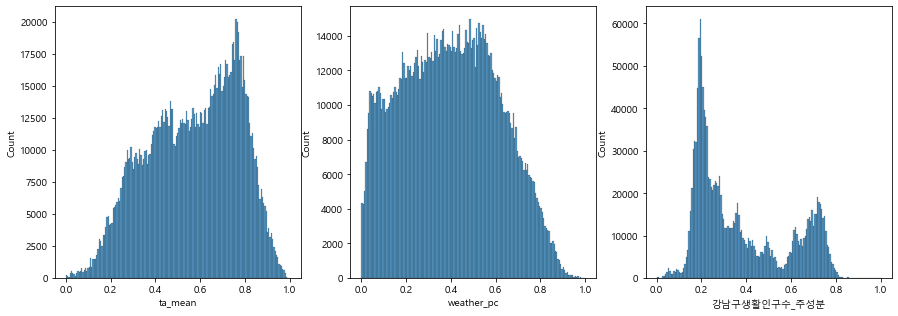

In [54]:
print("데이터의 특성을 확인하기 위한 히스토그램(샘플로 체크)")
sampleDf= pd.DataFrame(X, columns=features).sample(frac=0.05, random_state=11)
print("샘플사이즈: ", sampleDf.shape)

fig, ax = plt.subplots(1,3,figsize=(15,5))
for i, col in enumerate(["ta_mean","weather_pc","강남구생활인구수_주성분"]):
    sns.histplot(data=sampleDf, x=col, ax=ax[i])
plt.show()
del sampleDf

In [9]:
print("훈련 및 테스트 데이터 분할")
print("변수명")
print("X_tr_base: base 모델의 훈련용 X // y_tr_base: base 모델의 훈련용 y")
print("X_tt: base 모델이 예측에 사용할 X(=메타 모델이 예측 및 검증에 사용할 X)")
print("y_tt: base 모델을 검증할 y(=메타 모델이 예측 및 검증에 사용할 y)")
print("베이스 모델 훈련용: 60%, 메타 모델 훈령용: 30%, 검증용: 10%")

from sklearn.model_selection import train_test_split
X_tr_base, X_tt, y_tr_base, y_tt = train_test_split(X,y, train_size=0.6, shuffle=True, random_state=19)

print("X_tr_base 크기: ", X_tr_base.shape)
print("X_tt 크기: ", X_tt.shape)

훈련 및 테스트 데이터 분할
변수명
X_tr_base: base 모델의 훈련용 X // y_tr_base: base 모델의 훈련용 y
X_tt: base 모델이 예측에 사용할 X(=메타 모델이 예측 및 검증에 사용할 X)
y_tt: base 모델을 검증할 y(=메타 모델이 예측 및 검증에 사용할 y)
베이스 모델 훈련용: 60%, 메타 모델 훈령용: 30%, 검증용: 10%
X_tr_base 크기:  (18484117, 11)
X_tt 크기:  (12322746, 11)


## 베이스 모델 훈련 및 평가
- 현재까지의 모델 탐색 결과를 바탕으로 시간, 성능, 알고리즘의 다양성을 고려하여 스태킹을 위한 베이스 모델을 만든다.
- lgbm과 xgb의 경우 파라미터 최적화에 있어 앞서 가장 좋은 성능을 내었던 파라미터를 기준으로 랜덤 파라미터화를 통해 3개의 모델을 만든다.
- 선형회귀의 경우, 디폴트 값을 사용하되, 시간 효율성을 고려한다. 
<pre>
기준 파라미터
lgbm: n_estimators: 777, learning_rate=0.1, num_leaves=93
xgb: n_estimators: 333, gamma=5, learning_rate=0.3
선형모델: default
</pre>

### lgbm: leaf wise tree boosting

In [141]:
def randomizeParam():
    import numpy as np
    p={
        'colsample_bytree': round(np.random.uniform(0.4,1.0),2),
        'learning_rate': round(np.random.uniform(0.001,0.25),3),
        'min_child_samples': abs(int(np.random.normal(20,7))),
        'n_estimators': abs(int(np.random.normal(800,200))),
        'n_jobs': -1,
        'num_leaves': abs(int(np.random.normal(100,20))),
        'random_state': 19,
#         'reg_alpha': 0.0,
#         'reg_lambda': 0.0,
        'silent': 'warn',
        'subsample': 1.0,
        'subsample_for_bin': abs(int(np.random.normal(200000,30000))),
        'subsample_freq': 0,
        'verbose': 1
    }
    return p
print("최고의 점수를 냈던 파라미터 기준하여 랜덤으로 파라미터 생성하는 함수 예시",randomizeParam())

최고의 점수를 냈던 파라미터 기준하여 랜덤으로 파라미터 생성하는 함수 예시 {'colsample_bytree': 0.73, 'learning_rate': 0.1, 'min_child_samples': 13, 'n_estimators': 668, 'n_jobs': -1, 'num_leaves': 100, 'random_state': 19, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 273667, 'subsample_freq': 0, 'verbose': 1}


In [148]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import datetime
numModels=3

modelDicts={}
predDicts={}

r2Dicts={}
maeDicts={}
featDicts={}
for i in range(1,numModels+1):
    print(f"lgbm{i}번 모델링 시작")
    start=datetime.datetime.now()
    params = randomizeParam()
    l=LGBMRegressor(**params)
    y_pr=l.fit(X_tr_base, y_tr_base).predict(X_tt)
    
    modelDicts[f"lgbm{i}"] = l
    predDicts[f"lgbm{i}"] = y_pr
    
    r2=round(r2_score(y_tt, y_pr),3)
    mae=round(mean_absolute_error(y_tt,y_pr),3)
    
    print(f"lgbm {i} 결과:")
    print("r2: ", r2, "mae: ", mae)
    
    r2Dicts[f"lgbm{i}"]=r2
    maeDicts[f"lgbm{i}"]=mae
    
    featDicts[f"lgbm{i}"] = l.feature_importances_
    print("모델링 시간: ", datetime.datetime.now()-start)
    print(end="\n\n")
print("베이스모델 lgbm 모델링 완료")

lgbm1번 모델링 시작
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 18484117, number of used features: 11
[LightGBM] [Info] Start training from score 12.626243
lgbm 1 결과:
r2:  0.921 mae:  2.193
모델링 시간:  0:02:54.896543


lgbm2번 모델링 시작
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 18484117, number of used features: 11
[LightGBM] [Info] Start training from score 12.626243
lgbm 2 결과:
r2:  0.935 mae:  1.98
모델링 시간:  0:05:08.628148


lgbm3번 모델링 시작
[LightGBM] [W

### xgb: level wise tree boosting

In [199]:
def randomizeParamXgb():
    p={
        'n_estimators': abs(int(np.random.normal(350,70))),
        'learning_rate': round(np.random.uniform(0.25,0.35),2),
        'colsample_bytree': round(np.random.uniform(0.5,1.0),2),
        'colsample_bynode': round(np.random.uniform(0.5,1.0),2),
        'colsample_bylevel': round(np.random.uniform(0.5,1.0),2),
        'eval_metric': 'mae',
        'random_state': 19,
        'max_depth' : abs(int(np.random.uniform(4,9))),
        'gamma': round(np.random.uniform(0,5),2),
        'verbosity': 1
    }
    return p
randomizeParamXgb()

{'n_estimators': 388,
 'learning_rate': 0.27,
 'colsample_bytree': 0.61,
 'colsample_bynode': 0.55,
 'colsample_bylevel': 0.74,
 'eval_metric': 'mae',
 'random_state': 19,
 'max_depth': 4,
 'gamma': 1.18,
 'verbosity': 1}

In [200]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
for i in range(1,numModels+1):
    print(f"xgb{i}번 모델링 시작")
    start=datetime.datetime.now()
    print(start)
    params = randomizeParamXgb()
    print(params)

    xgb=XGBRegressor(**params)
    y_pr=xgb.fit(X_tr_base, y_tr_base).predict(X_tt)
    
    modelDicts[f"xgb{i}"] = xgb
    predDicts[f"xgb{i}"] = y_pr
    
    r2=round(r2_score(y_tt, y_pr),3)
    mae=round(mean_absolute_error(y_tt,y_pr),3)
    
    print(f"xgb {i} 결과:")
    print("r2: ", r2, "mae: ", mae)
    
    r2Dicts[f"xgb{i}"]=r2
    maeDicts[f"xgb{i}"]=mae
    
    featDicts[f"xgb{i}"] = xgb.feature_importances_
    print("모델링 시간: ", datetime.datetime.now()-start)
    print(end="\n\n")
print("베이스모델 xgb 모델링 완료")

xgb1번 모델링 시작
2024-06-19 15:08:28.583554
{'n_estimators': 284, 'learning_rate': 0.28, 'colsample_bytree': 0.55, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.88, 'eval_metric': 'mae', 'random_state': 19, 'max_depth': 7, 'gamma': 2.87, 'verbosity': 1}
xgb 1 결과:
r2:  0.845 mae:  2.978
모델링 시간:  0:12:16.768718


xgb2번 모델링 시작
2024-06-19 15:20:45.352272
{'n_estimators': 337, 'learning_rate': 0.25, 'colsample_bytree': 0.84, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.66, 'eval_metric': 'mae', 'random_state': 19, 'max_depth': 6, 'gamma': 3.05, 'verbosity': 1}
xgb 2 결과:
r2:  0.847 mae:  2.968
모델링 시간:  0:13:43.276256


xgb3번 모델링 시작
2024-06-19 15:34:28.628528
{'n_estimators': 264, 'learning_rate': 0.29, 'colsample_bytree': 0.75, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89, 'eval_metric': 'mae', 'random_state': 19, 'max_depth': 8, 'gamma': 0.17, 'verbosity': 1}
xgb 3 결과:
r2:  0.889 mae:  2.463
모델링 시간:  0:11:57.317175


베이스모델 xgb 모델링 완료


### 선형회귀 모델링
- 스태킹을 위하여 사용함

In [239]:
from sklearn.svm import LinearSVR
LinearSVR().get_params()

print(f"선형서포트벡터머신(lsvr) 모델링 시작")
start=datetime.datetime.now()
lsvr=LinearSVR(C=19, max_iter=30,verbose=1, random_state=19)
y_pr=lsvr.fit(X_tr_base, y_tr_base).predict(X_tt)

modelDicts[f"lsvr"] = lsvr
predDicts[f"lsvr"] = y_pr

r2=round(r2_score(y_tt, y_pr),3)
mae=round(mean_absolute_error(y_tt,y_pr),3)

print(f"lsvr 결과:")
print("r2: ", r2, "mae: ", mae)

r2Dicts[f"lsvr"]=r2
maeDicts[f"lsvr"]=mae

featDicts[f"lsvr"] = lsvr.coef_
print("모델링 시간: ", datetime.datetime.now()-start)
print(end="\n\n")

선형서포트벡터머신(lsvr) 모델링 시작
[LibLinear]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


lsvr 결과:
r2:  0.545 mae:  5.022
모델링 시간:  0:06:49.755779




In [13]:
# 선형 서포트 벡터 머신 리모델링 # 06.21. 추가작업
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, mean_absolute_error

print(f"선형서포트벡터머신(lsvr) 모델링 시작")
start=datetime.datetime.now()
lsvr=LinearSVR(verbose=1, random_state=19)
y_pr=lsvr.fit(X_tr_base, y_tr_base).predict(X_tt)

r2=round(r2_score(y_tt, y_pr),3)
mae=round(mean_absolute_error(y_tt,y_pr),3)

print(f"lsvr 결과:")
print("r2: ", r2, "mae: ", mae)

print("모델링 시간: ", datetime.datetime.now()-start)
print(end="\n\n")

선형서포트벡터머신(lsvr) 모델링 시작
[LibLinear]lsvr 결과:
r2:  0.541 mae:  4.894
모델링 시간:  0:04:49.223469




In [15]:
# 기존 결과에서 lsvr 부분만 교체한다 # 06.21 추가작업
with open("./모델링/lsvr.pkl",'wb') as f:
    pickle.dump(lsvr,f)

predDf=pd.read_csv("./모델링/베이스모델예측값(mlp훈련용).csv",index_col=0)
predDf['lsvr']=y_pr
predDf.to_csv("./모델링/베이스모델예측값(mlp훈련용).csv")

resDf=pd.read_csv("./모델링/모델링결과.csv")
resDf

,Unnamed: 0,구분,year,month,day,dayofyear,hour,minute,weekday,ta_mean,강남구생활인구수_주성분,weather_pc,r2,mae
0,lgbm1,15923.000000,3112.000000,2666.000000,1864.000000,6400.000000,7616.000000,823.000000,3044.000000,5296.000000,6734.000000,2192.000000,0.921,2.193
1,lgbm2,18085.000000,4318.000000,5149.000000,6126.000000,12765.000000,10782.000000,2374.000000,5237.000000,11510.000000,11958.000000,9676.000000,0.935,1.980
2,lgbm3,15711.000000,3036.000000,3814.000000,3931.000000,9420.000000,8314.000000,1538.000000,3957.000000,7951.000000,8420.000000,5640.000000,0.919,2.202
3,lr,23.827063,0.216605,6.780735,0.454138,0.077777,4.249351,-0.013473,0.559177,-0.999310,20.533129,0.976305,0.594,5.204
4,lsvr,16.144071,0.784581,5.761032,0.136799,0.928911,3.067285,1.085235,-0.579448,-1.132888,17.587253,1.104520,0.545,5.022
5,sgd,23.948841,0.570557,6.754079,0.322716,0.377473,4.465594,-0.141904,0.103172,-0.941847,20.651081,1.139529,0.593,5.260
6,xgb1,0.459892,0.011143,0.075475,0.003184,0.011269,0.105289,0.001316,0.043149,0.069188,0.211363,0.008730,0.845,2.978
7,xgb2,0.395195,0.021390,0.072003,0.003969,0.021746,0.202035,0.004836,0.016868,0.067372,0.148828,0.045760,0.847,2.968
8,xgb3,0.385094,0.024469,0.118828,0.002412,0.016842,0.049615,0.003580,0.022611,0.047486,0.323593,0.005471,0.889,2.463


In [181]:
from sklearn.linear_model import LinearRegression # 최소제곱법
print(f"선형회귀(lr) 모델링 시작")
start=datetime.datetime.now()
lr=LinearRegression()
y_pr=lr.fit(X_tr_base, y_tr_base).predict(X_tt)

modelDicts[f"lr"] = lr
predDicts[f"lr"] = y_pr

r2=round(r2_score(y_tt, y_pr),3)
mae=round(mean_absolute_error(y_tt,y_pr),3)

print(f"lr 결과:")
print("r2: ", r2, "mae: ", mae)

r2Dicts[f"lr"]=r2
maeDicts[f"lr"]=mae

featDicts[f"lr"] = lr.coef_
print("모델링 시간: ", datetime.datetime.now()-start)
print(end="\n\n")

선형회귀(lr) 모델링 시작
lr 결과:
r2:  0.594 mae:  5.204
모델링 시간:  0:00:10.677290




In [191]:
from sklearn.linear_model import SGDRegressor # 확률적 경사하강범
print(f"확률적 경사하강 회귀(sgd) 모델링 시작")
start=datetime.datetime.now()
params={
    'early_stopping': True, 'n_iter_no_change': 5, 'tol': 0.001,
    'verbose': 1, 'eta0':0.1
}
sgd=SGDRegressor(**params)
y_pr=sgd.fit(X_tr_base, y_tr_base).predict(X_tt)

modelDicts[f"sgd"] = sgd
predDicts[f"sgd"] = y_pr

r2=round(r2_score(y_tt, y_pr),3)
mae=round(mean_absolute_error(y_tt,y_pr),3)

print(f"sgd 결과:")
print("r2: ", r2, "mae: ", mae)

r2Dicts[f"sgd"]=r2
maeDicts[f"sgd"]=mae

featDicts[f"sgd"] = sgd.coef_
print("모델링 시간: ", datetime.datetime.now()-start)
print(end="\n\n")

확률적 경사하강 회귀(sgd) 모델링 시작
-- Epoch 1
Norm: 32.73, NNZs: 11, Bias: -12.889276, T: 16635705, Avg. loss: 25.218105
Total training time: 10.73 seconds.
-- Epoch 2
Norm: 32.25, NNZs: 11, Bias: -12.964097, T: 33271410, Avg. loss: 25.164747
Total training time: 23.21 seconds.
-- Epoch 3
Norm: 31.83, NNZs: 11, Bias: -12.957576, T: 49907115, Avg. loss: 25.150235
Total training time: 35.58 seconds.
-- Epoch 4
Norm: 32.60, NNZs: 11, Bias: -12.779293, T: 66542820, Avg. loss: 25.141840
Total training time: 48.10 seconds.
-- Epoch 5
Norm: 31.84, NNZs: 11, Bias: -12.897771, T: 83178525, Avg. loss: 25.136796
Total training time: 60.57 seconds.
-- Epoch 6
Norm: 32.69, NNZs: 11, Bias: -12.975957, T: 99814230, Avg. loss: 25.132102
Total training time: 73.04 seconds.
Convergence after 6 epochs took 74.79 seconds
sgd 결과:
r2:  0.593 mae:  5.26
모델링 시간:  0:01:19.812378




In [240]:
featDicts

{'lgbm1': array([15923,  3112,  2666,  1864,  6400,  7616,   823,  3044,  5296,
         6734,  2192]),
 'lgbm2': array([18085,  4318,  5149,  6126, 12765, 10782,  2374,  5237, 11510,
        11958,  9676]),
 'lgbm3': array([15711,  3036,  3814,  3931,  9420,  8314,  1538,  3957,  7951,
         8420,  5640]),
 'lr': array([ 2.38270635e+01,  2.16605375e-01,  6.78073503e+00,  4.54137797e-01,
         7.77769312e-02,  4.24935107e+00, -1.34730138e-02,  5.59176927e-01,
        -9.99310489e-01,  2.05331287e+01,  9.76305266e-01]),
 'lsvr': array([16.14407076,  0.78458068,  5.76103162,  0.1367994 ,  0.92891114,
         3.06728503,  1.08523513, -0.57944801, -1.13288825, 17.58725339,
         1.10451959]),
 'sgd': array([23.9488412 ,  0.57055687,  6.75407899,  0.32271557,  0.37747274,
         4.4655938 , -0.14190449,  0.10317174, -0.94184693, 20.65108136,
         1.13952887]),
 'xgb1': array([0.45989248, 0.01114297, 0.07547548, 0.00318424, 0.01126868,
        0.10528935, 0.00131632, 0.043148

## 베이스 모델 결과 확인 및 저장

In [241]:
import pickle
print("학습된 모델 확인 및 저장")

for modelName, modelObj in modelDicts.items():
    print(modelName)
    print(modelObj)
    with open(f"./모델링/{modelName}.pkl", 'wb') as f:
        pickle.dump(modelObj, f)
    print(f"{modelName} 저장완료")
    print(end='\n\n')

학습된 모델 확인 및 저장
lgbm1
LGBMRegressor(colsample_bytree=0.69, learning_rate=0.135, min_child_samples=14,
              n_estimators=586, num_leaves=96, random_state=19,
              subsample_for_bin=233604, verbose=1)
lgbm1 저장완료


lgbm2
LGBMRegressor(colsample_bytree=0.51, learning_rate=0.219, min_child_samples=18,
              n_estimators=1065, num_leaves=93, random_state=19,
              subsample_for_bin=236791, verbose=1)
lgbm2 저장완료


lgbm3
LGBMRegressor(colsample_bytree=0.56, learning_rate=0.136, min_child_samples=22,
              n_estimators=908, num_leaves=80, random_state=19,
              subsample_for_bin=175116, verbose=1)
lgbm3 저장완료


lr
LinearRegression()
lr 저장완료


lsvr
LinearSVR(C=19, max_iter=30, random_state=19, verbose=1)
lsvr 저장완료


sgd
SGDRegressor(early_stopping=True, eta0=0.125, verbose=1)
sgd 저장완료


xgb1
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.88, colsample_bynode=0.54,
             colsample_bytree=0.55, ear

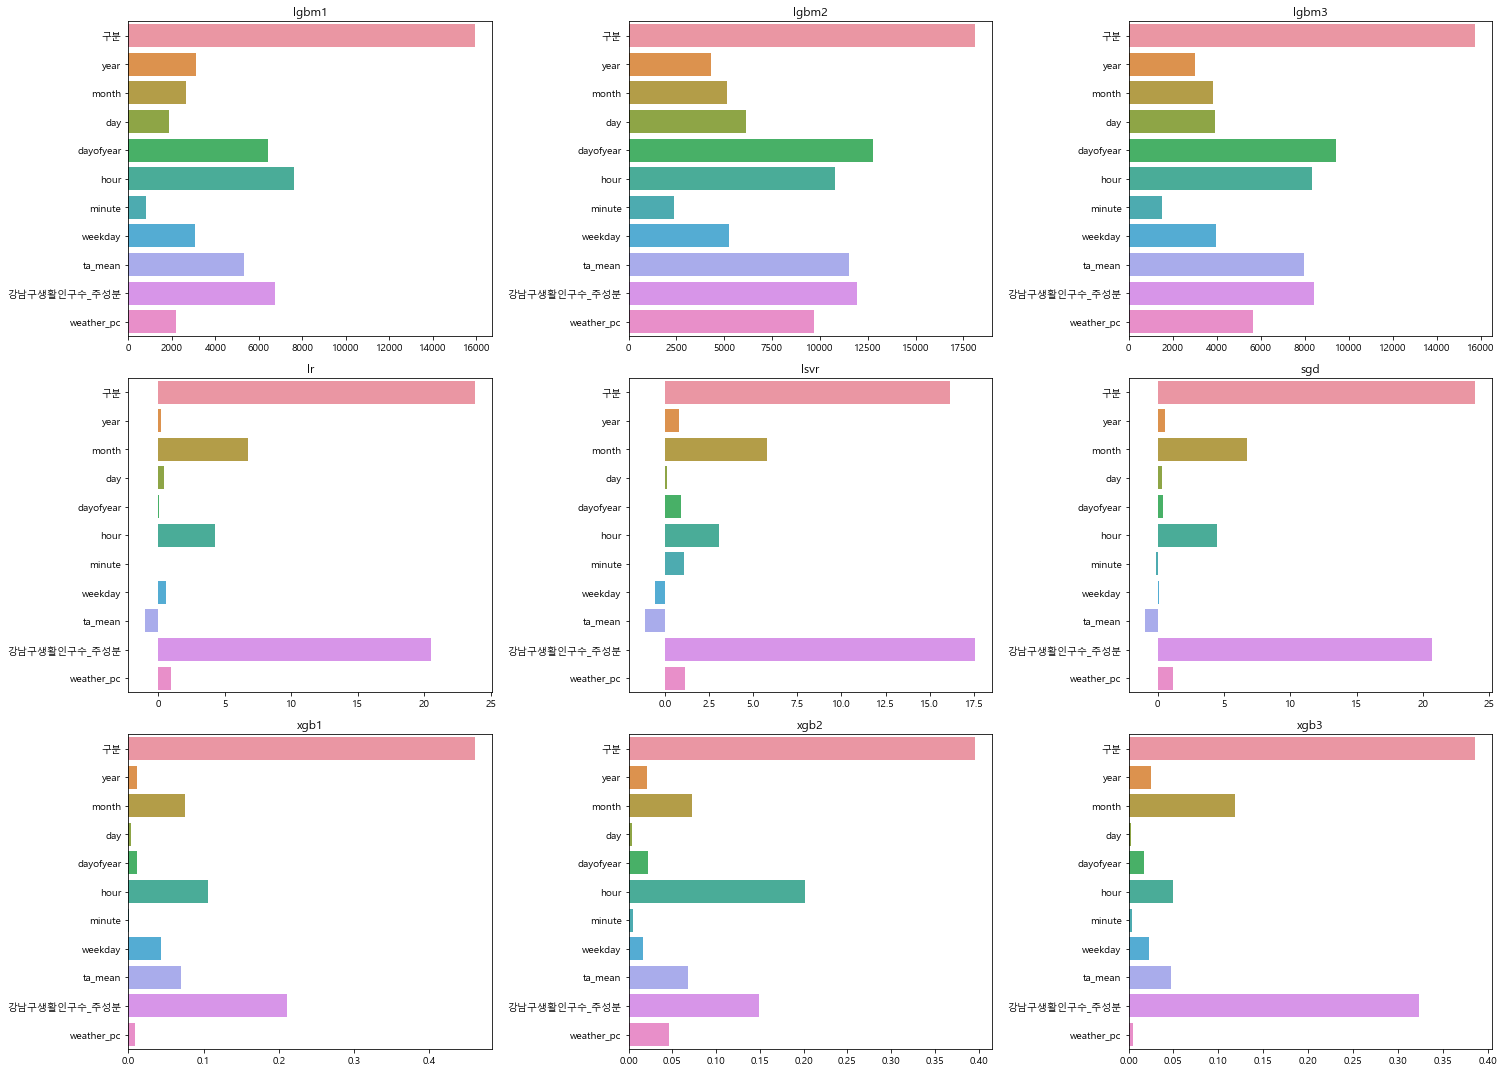

In [243]:
fig,ax = plt.subplots(3,3,figsize=(21,15))

featKeys=[k for k in featDicts.keys()]
k=0
for i in range(ax.shape[0]):
    for j in range(ax.shape[-1]):
        sns.barplot(x=featDicts[featKeys[k]], y=features, ax=ax[i,j])
        ax[i,j].set_title(f"{featKeys[k]}")
        k+=1
plt.tight_layout()
plt.savefig("./모델링/피쳐분석_전체.png")
plt.show()

del fig, ax, featKeys

In [246]:
resDf=pd.DataFrame(featDicts,index=features).T
resDf['r2']=r2Dicts.values()
resDf['mae']=maeDicts.values()
resDf.to_csv("./모델링/모델링결과.csv")
display(resDf.head())


,구분,year,month,day,dayofyear,hour,minute,weekday,ta_mean,강남구생활인구수_주성분,weather_pc,r2,mae
lgbm1,15923.000,3112.000,2666.000,1864.000,6400.000,7616.000,823.000,3044.000,5296.000,6734.000,2192.000,0.921,2.193
lgbm2,18085.000,4318.000,5149.000,6126.000,12765.000,10782.000,2374.000,5237.000,11510.000,11958.000,9676.000,0.935,1.980
lgbm3,15711.000,3036.000,3814.000,3931.000,9420.000,8314.000,1538.000,3957.000,7951.000,8420.000,5640.000,0.919,2.202
lr,23.827,0.217,6.781,0.454,0.078,4.249,-0.013,0.559,-0.999,20.533,0.976,0.594,5.204
lsvr,16.144,0.785,5.761,0.137,0.929,3.067,1.085,-0.579,-1.133,17.587,1.105,0.545,5.022


In [251]:
predDf=pd.DataFrame(predDicts)
predDf.to_csv("./모델링/베이스모델예측값(mlp훈련용).csv")
display(predDf.head())

,lgbm1,lgbm2,lgbm3,lr,lsvr,sgd,xgb1,xgb2,xgb3
0,3.400,3.286,3.216,0.044,3.413,0.189,2.939,3.644,3.207
1,8.496,8.821,8.770,12.972,11.530,13.383,7.455,6.212,7.698
2,9.452,8.107,8.463,14.716,12.874,14.843,9.813,9.052,9.856
3,6.255,6.221,6.330,6.341,8.344,6.883,6.971,6.343,6.222
4,14.813,11.000,12.215,17.489,14.617,18.031,16.387,14.617,12.756


## 메타 모델링: mlp regression

In [52]:
predDf= pd.read_csv("./모델링/베이스모델예측값(mlp훈련용).csv",index_col=0) # 06.21 lsvr을 기본 파라미터로 조정한 이후
predDf.head()

,lgbm1,lgbm2,lgbm3,lr,lsvr,sgd,xgb1,xgb2,xgb3
0,3.400,3.286,3.216,0.044,1.590,0.189,2.939,3.644,3.207
1,8.496,8.821,8.770,12.972,10.627,13.383,7.455,6.212,7.698
2,9.452,8.107,8.463,14.716,12.195,14.843,9.813,9.052,9.856
3,6.255,6.221,6.330,6.341,6.811,6.883,6.971,6.343,6.222
4,14.813,11.000,12.215,17.489,13.992,18.031,16.387,14.617,12.756


In [53]:
# 예측값을 하나의 
print("베이스 모델들에 의해 예측된 데이터의 크기: ", predDf.shape)
print("최종 훈련 및 검증용 세트로 분리")
from sklearn.model_selection import train_test_split
X_tr_mlp, X_tt_mlp, y_tr_mlp, y_tt_mlp = train_test_split(predDf.values, y_tt, train_size=0.75, random_state=19, shuffle=True)
print(X_tr_mlp.shape)
print(X_tt_mlp.shape)

베이스 모델들에 의해 예측된 데이터의 크기:  (12322746, 9)
최종 훈련 및 검증용 세트로 분리
(9242059, 9)
(3080687, 9)


### 인공신경망 구조 설계

In [54]:
from sklearn.neural_network import MLPRegressor
print(f"다층인공신경망(mlp) 모델링 시작")
params_mlp={
    'early_stopping': True, 'n_iter_no_change': 10, 'learning_rate_init':0.2,
    'hidden_layer_sizes': (64,), 'random_state': 19, 'verbose': True
}
mlp=MLPRegressor(**params_mlp)
mlp.fit(X_tr_mlp, y_tr_mlp)


다층인공신경망(mlp) 모델링 시작
Iteration 1, loss = 51.04402948
Validation score: 0.923916
Iteration 2, loss = 17.52809867
Validation score: 0.914998
Iteration 3, loss = 5.39817206
Validation score: 0.932142
Iteration 4, loss = 5.41196042
Validation score: 0.932526
Iteration 5, loss = 5.41004753
Validation score: 0.878048
Iteration 6, loss = 5.40493458
Validation score: 0.822936
Iteration 7, loss = 5.40863618
Validation score: 0.931533
Iteration 8, loss = 5.41278133
Validation score: 0.928921
Iteration 9, loss = 5.39246469
Validation score: 0.933288
Iteration 10, loss = 5.38314931
Validation score: 0.825736
Iteration 11, loss = 5.41619204
Validation score: 0.926305


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(early_stopping=True, hidden_layer_sizes=(64,),
             learning_rate_init=0.2, random_state=19, verbose=True)

In [262]:
print("히든 레이어, 학습률, n_iter_no_change 조정")
params_mlp={
    'early_stopping': True, 'n_iter_no_change': 5, 'learning_rate_init':0.1,
    'hidden_layer_sizes': (64,8,), 'random_state': 19, 'verbose': True
}
mlp=MLPRegressor(**params_mlp)
mlp.fit(X_tr_mlp, y_tr_mlp)

히든 레이어, 학습률, n_iter_no_change 조정
Iteration 1, loss = 32.98883090
Validation score: -0.000005
Iteration 2, loss = 68.75322092
Validation score: -0.000006
Iteration 3, loss = 68.75327119
Validation score: -0.000190


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(early_stopping=True, hidden_layer_sizes=(64, 8),
             learning_rate_init=0.1, n_iter_no_change=5, random_state=19,
             verbose=True)

In [57]:
print("히든 레이어, 학습률 조정")
params_mlp={
    'early_stopping': True, 'n_iter_no_change': 5, 'learning_rate_init':0.15,
    'hidden_layer_sizes': (128,), 'random_state': 19, 'verbose': True
}
mlp=MLPRegressor(**params_mlp)


히든 레이어, 학습률 조정
Iteration 1, loss = 25.14623099
Validation score: 0.921502
Iteration 2, loss = 8.57508439
Validation score: 0.935398
Iteration 3, loss = 5.11986576
Validation score: 0.905917
Iteration 4, loss = 5.09563137
Validation score: 0.930770
Iteration 5, loss = 5.08412128
Validation score: 0.919080
Iteration 6, loss = 5.08052250
Validation score: 0.917405
Iteration 7, loss = 5.09701004
Validation score: 0.924979
Iteration 8, loss = 5.08638135
Validation score: 0.934316
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


MLPRegressor(early_stopping=True, hidden_layer_sizes=(128,),
             learning_rate_init=0.15, n_iter_no_change=5, random_state=19,
             verbose=True)

In [64]:
mlp.fit(X_tr_mlp, y_tr_mlp)
## mlp의 최종 검증값 도출
y_pr_mlp=mlp.predict(X_tt_mlp)

r2=round(r2_score(y_tt_mlp, y_pr_mlp),3)
mae=round(mean_absolute_error(y_tt_mlp,y_pr_mlp),3)

print(f"mlp 결과(최종검증):")
print("r2: ", r2, "mae: ", mae)

print(end="\n\n")

mlp 결과(최종검증):
r2:  0.935 mae:  1.945




In [66]:
print("히든 레이어, 학습률 조정")
params_mlp={
    'early_stopping': True, 'n_iter_no_change': 3, 'learning_rate_init':0.15,
    'hidden_layer_sizes': (256,), 'random_state': 19, 'verbose': True
}
mlp=MLPRegressor(**params_mlp)
mlp.fit(X_tr_mlp, y_tr_mlp)

히든 레이어, 학습률 조정
Iteration 1, loss = 93.26749294
Validation score: 0.792100
Iteration 2, loss = 14.11132460
Validation score: 0.922270
Iteration 3, loss = 5.14050263
Validation score: 0.936337
Iteration 4, loss = 5.10277273
Validation score: 0.934388
Iteration 5, loss = 5.09955471
Validation score: 0.925104
Iteration 6, loss = 5.10625378
Validation score: 0.924887
Iteration 7, loss = 5.10072063
Validation score: 0.933135
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.


MLPRegressor(early_stopping=True, hidden_layer_sizes=(256,),
             learning_rate_init=0.15, n_iter_no_change=3, random_state=19,
             verbose=True)

In [68]:

## mlp의 최종 검증값 도출
y_pr_mlp=mlp.predict(X_tt_mlp)

r2=round(r2_score(y_tt_mlp, y_pr_mlp),3)
mae=round(mean_absolute_error(y_tt_mlp,y_pr_mlp),3)

print(f"mlp 결과(최종검증):")
print("r2: ", r2, "mae: ", mae)

print(end="\n\n")

mlp 결과(최종검증):
r2:  0.936 mae:  1.971




In [69]:
print("최종 mlp")
print("r2보단 mae가 낮은게 중요하다고 판단") ## 그래서 히든레이어가 128
params_mlp={
    'early_stopping': True, 'n_iter_no_change': 5, 'learning_rate_init':0.15,
    'hidden_layer_sizes': (128,), 'random_state': 19, 'verbose': True
}
mlp=MLPRegressor(**params_mlp)
mlp.fit(predDf.values, y_tt)

최종 mlp
r2보단 mae가 낮은게 중요하다고 판단
Iteration 1, loss = 36.51830528
Validation score: 0.913984
Iteration 2, loss = 5.44157860
Validation score: 0.932150
Iteration 3, loss = 5.10028447
Validation score: 0.936914
Iteration 4, loss = 5.09686419
Validation score: 0.937196
Iteration 5, loss = 5.11204664
Validation score: 0.923812
Iteration 6, loss = 5.08914458
Validation score: 0.926204
Iteration 7, loss = 5.09336128
Validation score: 0.933857
Iteration 8, loss = 5.10617448
Validation score: 0.923646
Iteration 9, loss = 5.08822528
Validation score: 0.922332
Iteration 10, loss = 5.09849778
Validation score: 0.934581
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


MLPRegressor(early_stopping=True, hidden_layer_sizes=(128,),
             learning_rate_init=0.15, n_iter_no_change=5, random_state=19,
             verbose=True)

In [70]:
## mlp 저장
import pickle
print("최종 누락구간 예측을 위하여 훈련 및 검증에 사용되었던 데이터도 학습")

print("mlp 학습에 사용된 데이터의 크기: ", predDf.shape)

with open("./최종모델/mlp.pkl", 'wb') as f:
    pickle.dump(mlp,f)
print("메타모델 mlp 저장완료")

최종 누락구간 예측을 위하여 훈련 및 검증에 사용되었던 데이터도 학습
mlp 학습에 사용된 데이터의 크기:  (12322746, 9)
메타모델 mlp 저장완료


### 예측수행

mlp 결과(최종검증):
r2:  0.937 mae:  1.937

In [2]:
import pickle
with open("mlp.pkl",'rb') as f:
    mlp=pickle.load(f)
mlp

MLPRegressor(early_stopping=True, hidden_layer_sizes=(128,),
             learning_rate_init=0.15, n_iter_no_change=5, random_state=19,
             verbose=True)